In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import numpy as np
import torch
import json

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle

import json
from glob import glob
import re
import copy

In [ ]:
ICL_model_path = # path to the model
model = AutoModelForCausalLM.from_pretrained(ICL_model_path, device_map="auto", torch_dtype=torch.float16)
tokenizer = AutoTokenizer.from_pretrained(ICL_model_path)

In [3]:
def parse_prompt_str(prompt_str):
    desc, ans = prompt_str.split(" Now please perform")
    ans = " Now please perform" + ans
    split_1 = desc.split("Dictionary used")
    header = split_1[0]

    descs = split_1[1:]
    for i in range(len(descs)):
        descs[i] = "Dictionary used" + descs[i]

    return header, descs, ans

def format_prompt_str(header, descs, ans):
    prompt_str = header
    for desc in descs:
        prompt_str += desc
    prompt_str += ans
    return prompt_str

In [4]:
ds_sample = json.load(open(ICL_model_path + "/ds_sample.json"))
sample_inputs = [qa['input'] + qa['labels'] for qa in ds_sample['outdist_Ton']]

In [ ]:
def visualize_distance_mat(mat, seq, xlim=None, ylim=None, merge_range=10):
    target_tokens = [tokenizer.decode(x) for x in seq]
    merged_ticks = []
    for i in range(0, len(target_tokens), merge_range):
        combined_str = ''.join(target_tokens[i:i+merge_range])
        combined_str = combined_str.replace("\n", " ").replace("<|reserved_special_token_100|>", "|T|")
        combined_str = re.sub(r'<[^>]*>', '', combined_str)
        merged_ticks.append(combined_str)

    plt.figure(figsize=(20, 6))
    plt.imshow(mat, aspect='auto', interpolation='nearest')
    plt.xticks(range(0, len(merged_ticks) * merge_range, merge_range), merged_ticks, rotation='vertical')

    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)

    plt.colorbar()
    plt.show()

def find_ans_start(token_seq):
    key_token = tokenizer.encode("<|begin_of_text|>")[1]
    for i in range(len(token_seq[0])):
        if token_seq[0][-i-1] == key_token:
            return len(token_seq[0]) - i

token_seq = tokenizer.encode(sample_inputs[0], return_tensors="pt")
ans_start = find_ans_start(token_seq)
ans_subset = token_seq[:, ans_start:]
ans = [tokenizer.decode(x) for x in ans_subset[0]]

In [ ]:
def visualize_distance_mat(mat, seq, xlim=None, ylim=None, merge_range=10):
    target_tokens = [tokenizer.decode(x) for x in seq]
    merged_ticks = []
    for i in range(0, len(target_tokens), merge_range):
        combined_str = ''.join(target_tokens[i:i+merge_range])
        combined_str = combined_str.replace("\n", " ").replace("<|reserved_special_token_100|>", "|T|")
        combined_str = re.sub(r'<[^>]*>', '', combined_str)
        combined_str = re.sub(r'\|T\|', '<T>', combined_str)
        merged_ticks.append(combined_str)

    plt.figure(figsize=(20, 6))
    plt.ylabel("Layer index")
    plt.imshow(mat, aspect='auto', interpolation='nearest')
    plt.xticks(range(0, len(merged_ticks) * merge_range, merge_range), merged_ticks, rotation='vertical')

    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)

    plt.colorbar()
    plt.show()

base_input = sample_inputs[0]
var_input = sample_inputs[1]

header, base_descs, ans = parse_prompt_str(base_input)
_, var_descs, _ = parse_prompt_str(var_input)

dist_mats = []

for swapped_entry in range(len(base_descs)):
    swapped_descs = copy.deepcopy(base_descs)
    swapped_descs[swapped_entry] = var_descs[swapped_entry]
    perturbed_prompt_str = format_prompt_str(header, swapped_descs, ans)

    perturbed_tokens = tokenizer.encode(perturbed_prompt_str, return_tensors="pt").to(model.device)
    clean_tokens = tokenizer.encode(base_input, return_tensors="pt").to(model.device)

    with torch.no_grad():
        clean_output = model(clean_tokens, return_dict=True, output_hidden_states=True)
        perturbed_output = model(perturbed_tokens, return_dict=True, output_hidden_states=True)
    clean_reps = torch.concat(clean_output.hidden_states, dim=0)
    perturbed_reps = torch.concat(perturbed_output.hidden_states, dim=0)

    distance_mat = torch.norm(clean_reps - perturbed_reps, dim=-1) ** 2
    dist_mats.append(distance_mat)

ans_start = find_ans_start(clean_tokens)
ans_inputs = clean_tokens[:, ans_start:]


In [ ]:
merge_range = 6 
target_tokens = [tokenizer.decode(x) for x in ans_inputs[0]]
print(target_tokens)
merged_ticks = []

for i in range(0, len(target_tokens), merge_range):
    combined_str = ''.join(target_tokens[i:i+merge_range])
    combined_str = combined_str.replace("\n", " ").replace("<|reserved_special_token_100|>", "|T|")
    combined_str = re.sub(r'<[^>]*>', '', combined_str)
    combined_str = re.sub(r'\|T\|', '<T>', combined_str)
    merged_ticks.append(combined_str)

print(merged_ticks)

marked_layers = [9, 16, 18, 21, 25]

fig = plt.figure(figsize=(15, 2), dpi=300)
gs = gridspec.GridSpec(1, len(dist_mats), wspace=0.1, hspace=0.1)

print(dist_mats[0].shape)

for i, mat in enumerate(dist_mats):
    ax = plt.subplot(gs[i])
    ax.set_title(r"Perturbing $\pi_{}$".format(i+1))
    vis_mat = mat.sqrt().cpu().numpy()[:, ans_start:]
    ax.hlines(marked_layers[i], 0, len(vis_mat[0]), color='white', linewidth=1, linestyles=":")
    ax.text(len(vis_mat[0])/2, marked_layers[i] - 2.5, "Layer {}".format(marked_layers[i] + 1), fontsize=9, ha='center', color='white')

    
    im = ax.imshow(vis_mat, aspect='auto', interpolation='nearest', origin='lower')

    # ax.set_xticks([], [])
    # ax.set_xticklabels([])
    # ax.set_yticks(list(range(0, len(vis_mat), 5)), list(range(0, len(vis_mat), 5)))
    ax.set_yticks(list(range(0, len(vis_mat), 5)), list(range(1, len(vis_mat) + 1, 5)))

    offset = 0.5
    ax.add_patch(Rectangle((0, offset-1), 230, 4, clip_on=False, alpha=0.5), )
    ax.add_patch(Rectangle((230, offset-1), len(vis_mat[0]) - 230, 4, clip_on=False, color='red', linewidth=0, alpha=0.5),)
    ax.text(125, offset, "Thought Tokens <T>...", fontsize=8, ha='center', color='white')
    ax.text(230 + (len(vis_mat[0]) - 230) // 2, offset, "Ans", fontsize=8, ha='center', color='white')
    if i == 0:
        ax.set_ylabel("Layer index")
    else:
        ax.set_yticklabels([])
    ax.set_xticks(range(0, len(vis_mat[0]), 50))
    ax.set_xlabel("Output Tokens")

    cbar = plt.colorbar(im)
    
plt.tight_layout()
plt.savefig("./figs/c8d5_rep_dist_flat.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

['The', ' translation', ' result', ' is', ':', ' Sequence', ' in', ' language', ' ', '1', ':', ' E', ' H', ' C', ' A', ' F', ' F', ' G', ' H', ' D', ' H', ' E', ' D', ' B', ' B', ' H', ' A', ' E', ' H', ' F', ' D', ' B', ' B', ' G', ' H', ' B', ' H', ' B', ' C', ' G', ' A', ' E', ' H', ' F', ' F', ' G', ' A', ';', ' Sequence', ' in', ' language', ' ', '2', ':', '<|reserved_special_token_100|>', '<|reserved_special_token_100|>', '<|reserved_special_token_100|>', '<|reserved_special_token_100|>', '<|reserved_special_token_100|>', '<|reserved_special_token_100|>', '<|reserved_special_token_100|>', '<|reserved_special_token_100|>', '<|reserved_special_token_100|>', '<|reserved_special_token_100|>', '<|reserved_special_token_100|>', '<|reserved_special_token_100|>', '<|reserved_special_token_100|>', '<|reserved_special_token_100|>', '<|reserved_special_token_100|>', '<|reserved_special_token_100|>', '<|reserved_special_token_100|>', '<|reserved_special_token_100|>', '<|reserved_special_toke

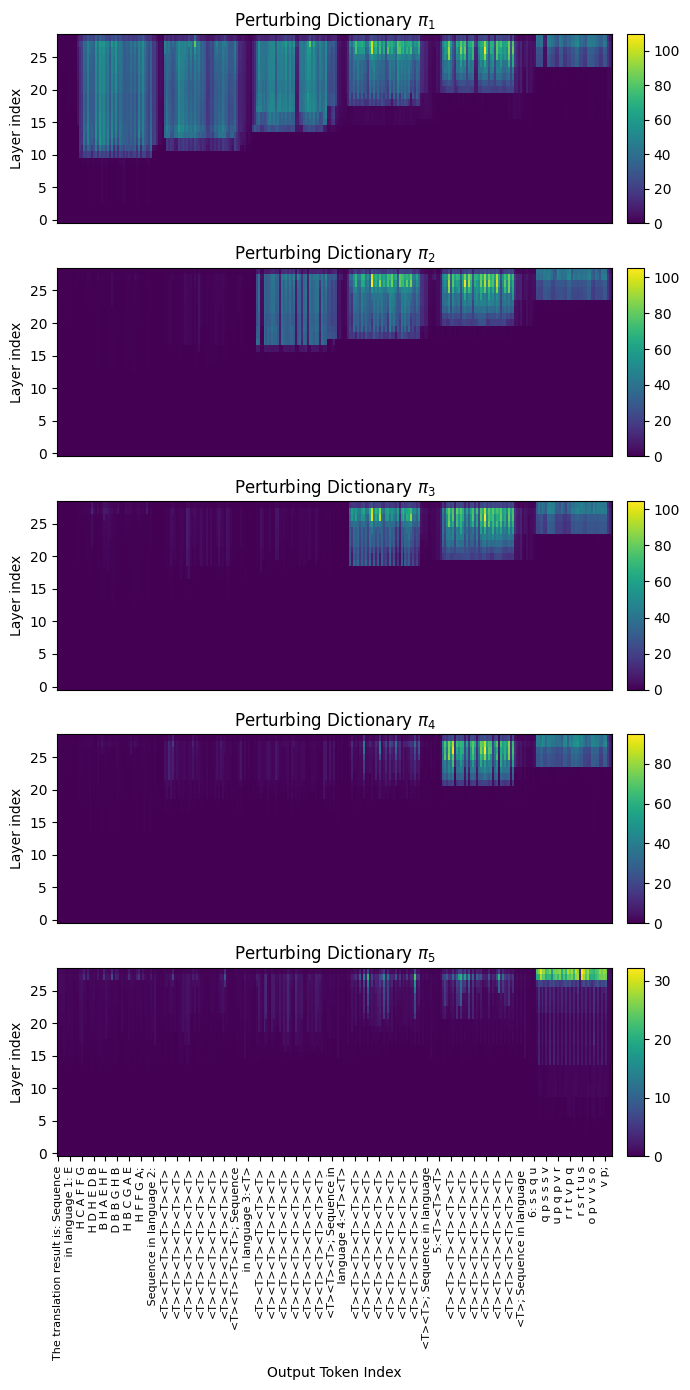

In [ ]:
merge_range = 6 
target_tokens = [tokenizer.decode(x) for x in ans_inputs[0]]
print(target_tokens)
merged_ticks = []

for i in range(0, len(target_tokens), merge_range):
    combined_str = ''.join(target_tokens[i:i+merge_range])
    combined_str = combined_str.replace("\n", " ").replace("<|reserved_special_token_100|>", "|T|")
    combined_str = re.sub(r'<[^>]*>', '', combined_str)
    combined_str = re.sub(r'\|T\|', '<T>', combined_str)
    merged_ticks.append(combined_str)

print(merged_ticks)

plt.figure(figsize=(7, 14))
gs = gridspec.GridSpec(len(dist_mats), 2, width_ratios=[10, 0.3])

for i, mat in enumerate(dist_mats):
    ax = plt.subplot(gs[i,0])
    ax.set_title(r"Perturbing Dictionary $\pi_{}$".format(i+1))
    im = ax.imshow(mat.sqrt().cpu().numpy()[:, ans_start:], aspect='auto', interpolation='nearest', origin='lower')
    ax.set_xticks([], [])
    ax.set_ylabel("Layer index")
    cbar = plt.colorbar(im, cax=plt.subplot(gs[i, 1]))
    
ax.set_xticks(range(0, len(merged_ticks) * merge_range, merge_range))
ax.set_xticklabels(merged_ticks, rotation='vertical', fontsize=8)
ax.set_xlabel("Output Token Index")
plt.tight_layout()
plt.savefig("./figs/c8d5_rep_dist.pdf", bbox_inches='tight', pad_inches=0)
plt.show()
